# Importing configurations and modules

In [1]:
import numpy as np
import pandas as pd

In [2]:
from config.config import *
from callbacks.callbacks import *

2024-11-18 17:46:46.753915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 17:46:46.950417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731932207.048411  102857 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731932207.073010  102857 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 17:46:47.290527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU (UUID: GPU-3c98d5c3-b19e-acfa-02d3-5c9d5dfaedd2)


# Data processing and understanding

In [4]:
DATA_DIR = DATASET_DIR.joinpath('pubmed-rct')

In [5]:
os.listdir(DATA_DIR)

['PubMed_200k_RCT',
 'PubMed_20k_RCT',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign']

In [6]:
DATASET = 'PubMed_20k_RCT_numbers_replaced_with_at_sign'
DATA_FILES = [DATA_DIR.joinpath(DATASET).joinpath(x) for x in os.listdir(DATA_DIR.joinpath(DATASET))]

In [7]:
DATA_FILES

[PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')]

In [8]:
data = dict()
for path in DATA_FILES:
    with open(path) as file:
        data[file.name.split('/')[-1].split('.')[0]] = file.readlines()

In [9]:
data.keys()

dict_keys(['test', 'train', 'dev'])

In [10]:
start = 0
amount = 20
for key in data:
    print('--------------------------------------------------------------------------------------------------\nData from Dataset', key)
    print(np.array(data[key][start: start+amount]))

--------------------------------------------------------------------------------------------------
Data from Dataset test
['###24845963\n'
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n'
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n'
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n'
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n'
 "RESULTS\tT

## To be more computer friendlty let's preprocess using a function

In [11]:
def process_data(file_name : str) -> list:
    """
    Process a structured text file containing abstracts and convert it into a list of dictionaries.

    Parameters:
        file_name: str
            Path to the input file.
            Expected file format:
            - Abstract headers marked with '###' followed by ID
            - Each line contains tab-separated target and text
            - Abstracts separated by blank lines

    Returns:
        List[Dict[str, Union[str, int]]]: A list of dictionaries, where each dictionary contains:
            - target (str): The target label from the input
            - text (str): The lowercase text content
            - line_number (int): Line position within the abstract (0-based)
            - total_lines (int): Total number of lines in the abstract
            - abstract_id (int): ID extracted from the abstract header

    Raises:
        FileNotFoundError: If the specified file does not exist
        IOError: If there are issues reading the file
        ValueError: If:
            - Abstract ID cannot be converted to integer
            - Line doesn't contain enough tab-separated fields
            - Malformed header line (missing '###' or ID)
        IndexError: If trying to access parts of malformed lines
        TypeError: If file_name is not a string

    Example:
        >>> data = process_data('abstracts.txt')
        >>> print(data[0])
        {
            'target': 'BACKGROUND',
            'text': 'example text here',
            'line_number': 0,
            'total_lines': 5,
            'abstract_id': 1234
        }

    Notes:
        - Text is automatically converted to lowercase for processing efficiency
        - Abstract headers must start with '###' followed by ID
        - Each abstract must end with a blank line
        - Lines must contain at least two tab-separated fields
    """
    data = list()
    with open(file_name) as file:
        data_lines = file.readlines()
    for line in data_lines:
        if line[:3] == '###':
            line_number = 0
            id = line[4:-2]
            abstract = []
            continue
        elif line == '\n':
            for item in abstract:
                item['total_lines'] = line_number
                data.append(item)
        else:
            target, text = line.split('\t')[:2]
            abstract.append(
                {
                    'target' : target,
                    'text' : text.lower(), #lowercase for efficiency
                    'line_number' : line_number,
                    'total_lines' : 0,
                    'abstract_id' : int(id)
                    }
            )
        line_number+=1
    return data

In [12]:
%%time

test = process_data(DATA_FILES[0])
train = process_data(DATA_FILES[1])
val = process_data(DATA_FILES[2])

len(test) ,len(train), len(val)

CPU times: user 442 ms, sys: 205 ms, total: 646 ms
Wall time: 646 ms


(30135, 180040, 30212)

In [13]:
test = process_data(DATA_FILES[0])
train = process_data(DATA_FILES[1])
val = process_data(DATA_FILES[2])
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
val_df = pd.DataFrame(val)

## Visualizing the processed data

In [14]:
train_df.head(20)

,target,text,line_number,total_lines,abstract_id
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12,429357
1,METHODS,a total of @ patients with primary knee oa wer...,1,12,429357
2,METHODS,outcome measures included pain reduction and i...,2,12,429357
3,METHODS,pain was assessed using the visual analog pain...,3,12,429357
4,METHODS,secondary outcome measures included the wester...,4,12,429357
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12,429357
6,RESULTS,there was a clinically relevant reduction in t...,6,12,429357
7,RESULTS,the mean difference between treatment arms ( @...,7,12,429357
8,RESULTS,"further , there was a clinically relevant redu...",8,12,429357
9,RESULTS,these differences remained significant at @ we...,9,12,429357


In [15]:
NUM_CLASSES = train_df['target'].nunique()
train_df['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [16]:
def word_count(text : str):
    return len([x for x in text.split()])

word_counts = train_df['text'].apply(word_count)

<Axes: ylabel='Frequency'>

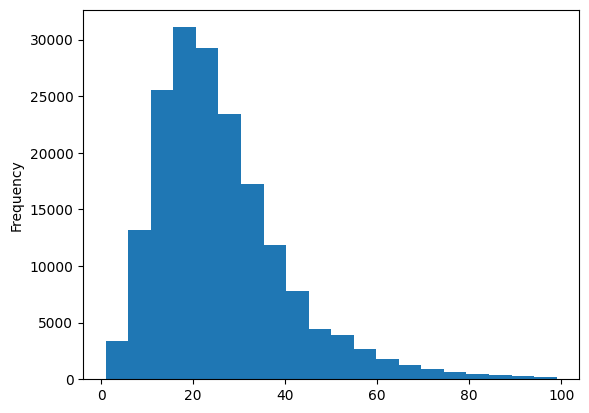

In [17]:
word_counts[word_counts < 100].plot.hist(bins = 20)

<Axes: ylabel='Frequency'>

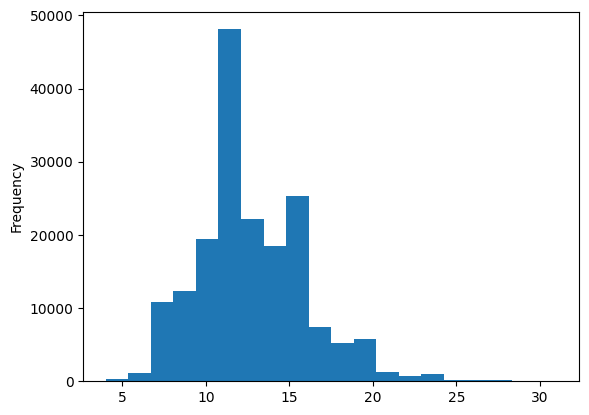

In [18]:
train_df.total_lines.plot.hist(bins = 20)

In [19]:
X_train = train_df['text'].to_numpy()
X_test = test_df['text'].to_numpy()
X_val = val_df['text'].to_numpy()

## Converting labels to numerical format

### One Hot

In [20]:
# Same results using sklearn
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(sparse_output=False)
train_one_hot = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_one_hot = one_hot.transform(test_df['target'].to_numpy().reshape(-1,1))
val_one_hot = one_hot.transform(val_df['target'].to_numpy().reshape(-1,1))

In [21]:
train_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoding

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_label = label_encoder.fit_transform(train_df['target'].to_numpy())
test_label = label_encoder.transform(test_df['target'].to_numpy())
val_label = label_encoder.transform(val_df['target'].to_numpy())

In [23]:
train_label

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
CLASS_NAMES  = label_encoder.classes_

In [25]:
CLASS_NAMES

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Creating Model Baseline

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB 
from sklearn.feature_extraction.text import TfidfVectorizer

model_0 = Pipeline(
    steps=[
        ('vectorizer', TfidfVectorizer()),
        ( 'clf', MultinomialNB())
    ]
)

In [27]:
model_0.fit(X_train, train_label)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
baseline_preds = model_0.predict(X_val)

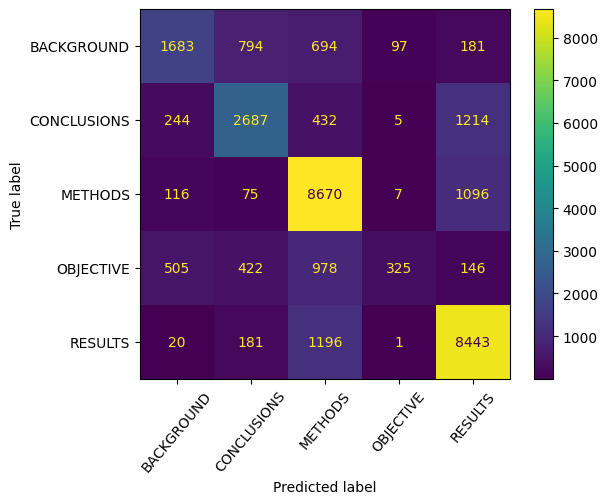

In [29]:
from evaluation import get_cm_and_final_results
_, _, baseline_metrics = get_cm_and_final_results(baseline_preds, val_label)

In [31]:
baseline_metrics

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}